# openEO use case for floods - UC11

## GFM

The Global Flood Monitoring (GFM) product is a component of the EU’s Copernicus
Emergency Management Service (CEMS) that provides continuous monitoring of
floods worldwide, by processing and analysing in near real-time all
incoming Sentinel-1 SAR acquisitions over land.

The operational implementation the GFM product includes the following key
elements:
- Downloading of worldwide Sentinel-1 SAR acquisitions (Level-1 IW GRDH)
- Pre-processing of the downloaded Sentinel-1 data to backscatter data (SIG0)
- Operational application of three fully automated flood mapping algorithms.
- An ensemble-based approach is then used to combine the three flood extent
  outputs of the individual flood algorithms.
- Generation of the required GFM output layers, including Observed flood extent,
  Reference water mask, Exclusion Mask and Likelihood Values
- Web service-based access and dissemination of the GFM product output layers

### Output layers used in this notebook
- Observed flood extent (ENSEMBLE of all three individual flood outputs)
- Reference water mask (permament and seasonal water bodies)

### Links
https://extwiki.eodc.eu/GFM

### Connect and authenticate to openEO

In [64]:
import openeo
from openeo.processes import *

backend = "openeo.cloud"
conn = openeo.connect(backend)
conn = conn.authenticate_oidc()

Authenticated using refresh token.


### Describe the GFM collection

In [ ]:
conn.describe_collection("GFM")

### Sum of flooded_pixel over time

In [ ]:
spatial_extent  = {'west': 67.5, 'east': 70, 'south': 24.5, 'north': 26}
temporal_extent = ["2022-09-01", "2022-10-01"] 
collection      = 'GFM'

gfm_data = conn.load_collection(
    collection, 
    spatial_extent=spatial_extent, 
    temporal_extent=temporal_extent, 
    bands = ["flood_extent"]
)
gfm_sum = gfm_data.reduce_dimension(dimension="time", reducer=sum)

gfm_sum_tiff = gfm_sum.save_result(format="GTiff", options={"tile_grid": "wgs84-1degree"})

In [ ]:
job = gfm_sum_tiff.create_job(title = "UC11")
jobId = job.job_id
job.start_job()

In [ ]:
job.status()

In [ ]:
results = job.get_results()
metadata = results.get_metadata()
results.download_files("./gfm/flood_extent_wgs/")

### Load the downloaded result files

In [65]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

path = "./gfm/flood_extent_wgs/"
files = [path + file for file in os.listdir(path) if file.startswith("WGS84") and file.endswith(".tif")]
flood_extent = xr.open_mfdataset(files)
flood_extent = flood_extent.band_data.sel(band=1)

### Explore how the flood extent relates to the Global Human Settlement Built-up layer

The Global Human Settlement Layer (GHSL) project produces global spatial 
information about the human presence on the planet over time in the form of 
built-up maps, population density maps and settlement maps.

Here, the GHS-BUILT-S spatial raster dataset at 10m resolution is used which 
depicts the distribution of built-up surfaces, expressed as number of square metres.

Values are between 0 and 100 and represent the amount of square metres of
built-up surface in the cell. 

https://ghsl.jrc.ec.europa.eu/about.php

In [66]:
import s3fs
import xarray as xr
S3_URL_CENTRAL = "https://s3.central.data.destination-earth.eu"
s3_central = s3fs.S3FileSystem(
    anon=True,
    use_ssl=True,
    client_kwargs={"endpoint_url": S3_URL_CENTRAL},
)
ghsl = xr.open_zarr(store=s3fs.S3Map(
    root="increment1-testdata/built_data.zarr", 
    s3=s3_central, 
    check=False),
    decode_coords="all"
)
display(ghsl.built)

min_lat, max_lat = 25.1, 25.2
min_lon, max_lon = 69.1, 69.2

ghsl = ghsl.built.sel(x=slice(min_lon, max_lon), y=slice(max_lat, min_lat))
display(ghsl)

<xarray.DataArray 'built' (y: 68116, x: 112644)>
dask.array<open_dataset-built, shape=(68116, 112644), dtype=float32, chunksize=(1000, 1000), chunktype=numpy.ndarray>
Coordinates:
    band         int64 ...
    spatial_ref  int64 ...
  * x            (x) float64 64.02 64.02 64.02 64.02 ... 73.03 73.03 73.03 73.03
  * y            (y) float64 30.0 30.0 30.0 30.0 ... 24.55 24.55 24.55 24.55
Attributes:
    AREA_OR_POINT:  Area

<xarray.DataArray 'built' (y: 1251, x: 1251)>
dask.array<getitem, shape=(1251, 1251), dtype=float32, chunksize=(980, 779), chunktype=numpy.ndarray>
Coordinates:
    band         int64 ...
    spatial_ref  int64 ...
  * x            (x) float64 69.1 69.1 69.1 69.1 69.1 ... 69.2 69.2 69.2 69.2
  * y            (y) float64 25.2 25.2 25.2 25.2 25.2 ... 25.1 25.1 25.1 25.1
Attributes:
    AREA_OR_POINT:  Area

In [68]:
min_lat, max_lat = np.min(ghsl.y.values), np.max(ghsl.y.values)
min_lon, max_lon = np.min(ghsl.x.values), np.max(ghsl.x.values)

flood_extent = flood_extent.sel(x=slice(min_lon, max_lon), y=slice(max_lat, min_lat))
flood_extent = xr.where(flood_extent == 0, np.nan, flood_extent)
display(flood_extent)

<xarray.DataArray 'band_data' (y: 556, x: 555)>
dask.array<where, shape=(556, 555), dtype=float32, chunksize=(392, 468), chunktype=numpy.ndarray>
Coordinates:
    band         int64 1
  * x            (x) float64 69.1 69.1 69.1 69.1 69.1 ... 69.2 69.2 69.2 69.2
  * y            (y) float64 25.2 25.2 25.2 25.2 25.2 ... 25.1 25.1 25.1 25.1
    spatial_ref  int64 0

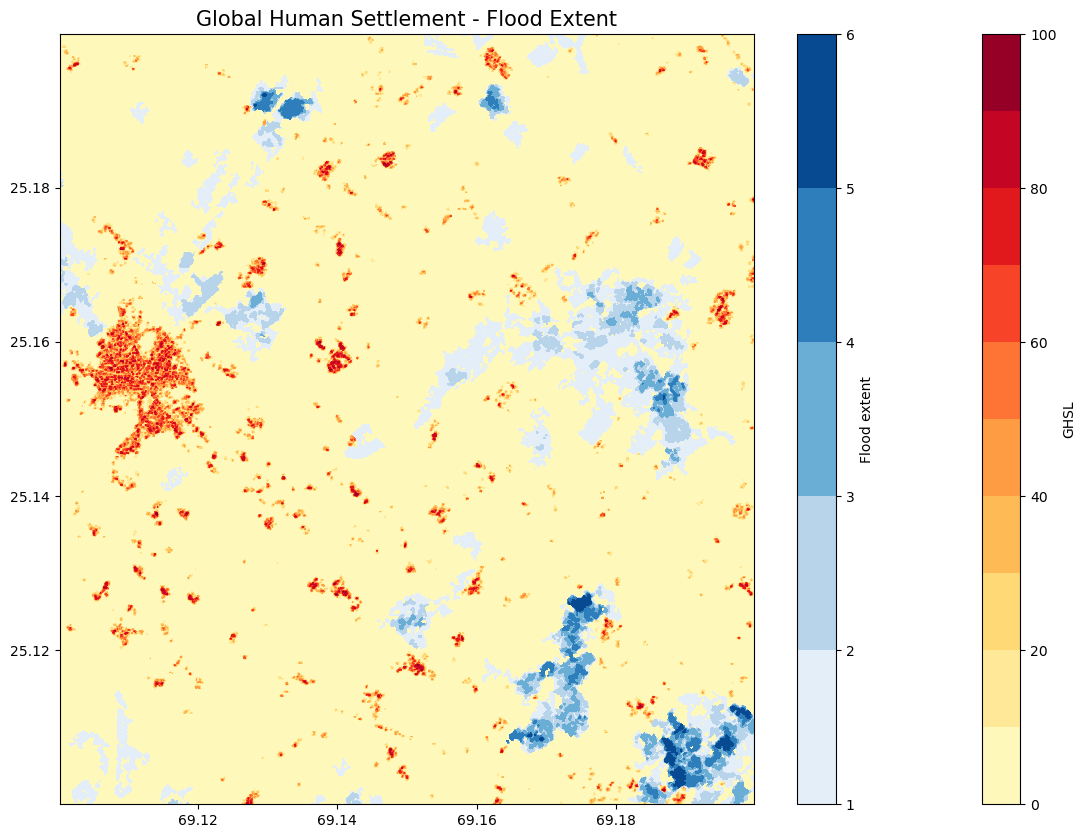

In [35]:
plt.figure(figsize=(14,10))
plt.title("Global Human Settlement - Flood Extent", fontsize=15)
X, Y = np.meshgrid(ghsl.x.values, ghsl.y.values)
g = plt.contourf(X, Y, ghsl.built,cmap='YlOrRd', levels=10)
plt.colorbar(label="GHSL")
X, Y = np.meshgrid(flood_extent.x.values, flood_extent.y.values)
f = plt.contourf(X, Y, flood_extent,cmap='Blues', levels=5)
plt.colorbar(label="Flood extent")

### Observed water (flood_extent + refwater)

The observed water combines both flood extent and the reference water mask. The reference water mask represents permanent or seasonal water bodies, which are clearly distinct from flood events.

In [42]:
spatial_extent  = {'west': 67.5, 'east': 70, 'south': 24.5, 'north': 26}
temporal_extent = ["2022-09-01", "2022-10-01"] 
collection      = 'GFM'

gfm_data = conn.load_collection(
    collection, 
    spatial_extent=spatial_extent, 
    temporal_extent=temporal_extent, 
    bands = ["flood_extent", "refwater"]
)

# retrieve all pixels which have been detected as water during the given period
# -> observed water
observed_water = gfm_data.reduce_dimension(dimension="bands", reducer=any).reduce_dimension(dimension="time", reducer=any)

# Save the result in Equi7Grid and as GeoTiff
observed_water_tif = observed_water.save_result(format="GTiff", options={"tile_grid": "equi7"})

In [43]:
job = observed_water_tif.create_job(title = "UC11")
jobId = job.job_id
job.start_job()

<BatchJob job_id='eodc-2cd4298f-7237-4989-9159-346703e4dfcd'>

In [49]:
job.status()

'finished'

In [50]:
results = job.get_results()
metadata = results.get_metadata()
results.download_files("./gfm/observed_water/")

[PosixPath('gfm/observed_water/AS020M_E015N024T3_20220901T010907.tif'),
 PosixPath('gfm/observed_water/AS020M_E015N027T3_20220901T010907.tif'),
 PosixPath('gfm/observed_water/AS020M_E018N024T3_20220901T010907.tif'),
 PosixPath('gfm/observed_water/AS020M_E018N027T3_20220901T010907.tif'),
 PosixPath('gfm/observed_water/job-results.json')]

In [51]:
path = "./gfm/observed_water/"
files = [path + file for file in os.listdir(path) if file.startswith("AS") and file.endswith(".tif")]
# we expect only 0 and 1 -> bool
data = xr.open_mfdataset(files).astype("bool")
d = data.band_data
display(d)

<xarray.DataArray 'band_data' (band: 1, y: 11879, x: 14489)>
dask.array<astype, shape=(1, 11879, 14489), dtype=bool, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 1.621e+06 1.621e+06 1.621e+06 ... 1.91e+06 1.91e+06
  * y            (y) float64 2.89e+06 2.89e+06 2.89e+06 ... 2.653e+06 2.653e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:                 Area
    filepaths:                     None
    snapshot_STAC_collection_URL:  https://dev.stac.eodc.eu/api/v1/collection...

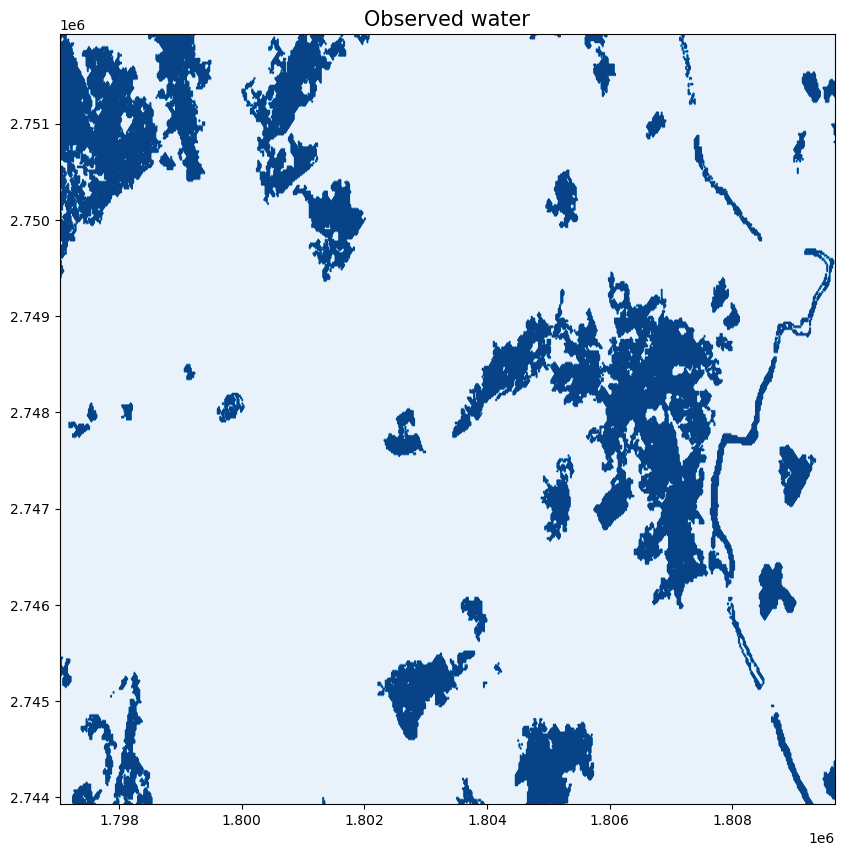

In [63]:
plt.figure(figsize=(10,10))
plt.title("Observed water", fontsize=15)
d_small = d.sel(band=1, x=slice(1797025,1809688), y=slice(2751932,2743913))
X, Y = np.meshgrid(d_small.x.values, d_small.y.values)
plt.contourf(X, Y, d_small, cmap='Blues')